In [4]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from os.path import join

IRRELEVANT_COLUMNS = [
    'experiment_id', 'timestamp', 'time_this_iter_s',
    'time_total_s', 'pid', 'hostname', 'node_ip', 'config',
    'time_since_restore', 'timesteps_since_restore',
    'iterations_since_restore', 'perf', 'sampler_perf',
    'num_healthy_workers'
]

In [5]:
def load_and_trim_df(path: str) -> pd.DataFrame:
    split_path = path.split(os.sep)
    trainer_type, intersection = split_path[2:4]
    df = pd.read_csv(path)
    df["trainer_type"] = [trainer_type] * len(df)
    df["intersection"] = [intersection] * len(df)
    df.drop(labels=IRRELEVANT_COLUMNS, inplace=True, axis=1)
    return df

In [6]:
fedrl_dfs = [
    load_and_trim_df(join("out", "data", "FedRL", "grid-3x3", "unranked.csv")),
    load_and_trim_df(join("out", "data", "FedRL", "grid-5x5", "unranked.csv")),
    load_and_trim_df(join("out", "data", "FedRL", "double", "unranked.csv")),
    # load_and_trim_df(join("out", "data", "FedRL", "grid", "ranked.csv"))
]

marl_dfs = [
    load_and_trim_df(join("out", "data", "MARL", "grid-3x3", "unranked.csv")),
    load_and_trim_df(join("out", "data", "MARL", "grid-5x5", "unranked.csv")),
    load_and_trim_df(join("out", "data", "MARL", "double", "unranked.csv")),
    # load_and_trim_df(join("out", "data", "MARL", "grid", "ranked.csv"))
]

sarl_dfs = [
    load_and_trim_df(join("out", "data", "SARL", "grid-3x3", "unranked.csv")),
    load_and_trim_df(join("out", "data", "SARL", "grid-5x5", "unranked.csv")),
    load_and_trim_df(join("out", "data", "SARL", "double", "unranked.csv")),
    # load_and_trim_df(join("out", "data", "SARL", "grid", "ranked.csv"))
]

df = pd.concat(fedrl_dfs + marl_dfs + sarl_dfs)
print(f"Data Columns: {df.columns}\n")
df.head()

Data Columns: Index(['Unnamed: 0', 'round', 'trainer', 'policy', 'fed_round',
       'episode_reward_max', 'episode_reward_min', 'episode_reward_mean',
       'episode_len_mean', 'episode_media', 'episodes_this_iter',
       'policy_reward_min', 'policy_reward_max', 'policy_reward_mean',
       'custom_metrics', 'hist_stats', 'off_policy_estimator',
       'timesteps_total', 'agent_timesteps_total', 'timers', 'info', 'done',
       'episodes_total', 'training_iteration', 'date', 'callback_ok',
       'trainer_type', 'intersection'],
      dtype='object')



,Unnamed: 0,round,trainer,policy,fed_round,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,...,agent_timesteps_total,timers,info,done,episodes_total,training_iteration,date,callback_ok,trainer_type,intersection
0,0,0,FedRL,A0,False,-8.158296,-14.921656,-12.495635,396.5,{},...,36000,"{'sample_time_ms': 203801.927, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3
1,1,0,FedRL,A1,False,-8.158296,-14.921656,-12.495635,396.5,{},...,36000,"{'sample_time_ms': 203801.927, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3
2,2,0,FedRL,A2,False,-8.158296,-14.921656,-12.495635,396.5,{},...,36000,"{'sample_time_ms': 203801.927, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3
3,3,0,FedRL,B0,False,-8.158296,-14.921656,-12.495635,396.5,{},...,36000,"{'sample_time_ms': 203801.927, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3
4,4,0,FedRL,B1,False,-8.158296,-14.921656,-12.495635,396.5,{},...,36000,"{'sample_time_ms': 203801.927, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3


In [7]:
print(df["off_policy_estimator"])

0    {}
1    {}
2    {}
3    {}
4    {}
     ..
1    {}
0    {}
1    {}
0    {}
1    {}
Name: off_policy_estimator, Length: 84, dtype: object


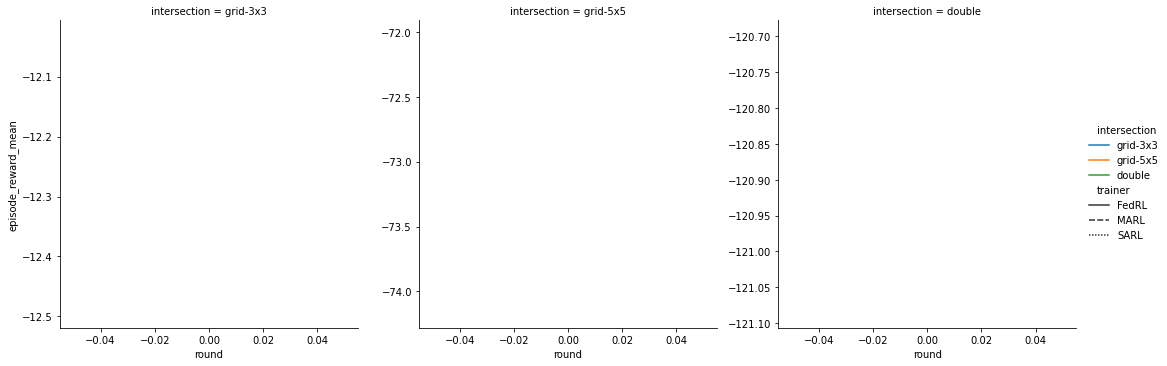

In [8]:
sns.relplot(
    data=df, 
    kind="line", 
    x="round", 
    y="episode_reward_mean", 
    style="trainer", 
    hue="intersection", 
    col="intersection",
    # col_wrap=2,
    facet_kws={"sharey": False},
    ci=None
)
plt.show()

In [9]:
import ast

TYPE_SPLITTER = "___"
COMM_TYPES = set(['edge_to_tls_action_comms', 'edge_to_tls_policy_comms', 'edge_to_tls_rank_comms', 
                  'tls_to_edge_obs_comms', 'tls_to_edge_policy_comms', 'veh_to_tls_info_comms'])
FED_COMM_TYPES = set(['edge_to_tls_policy_comms', 'tls_to_edge_policy_comms'])

def sum_comm_cost(data, comm_type, fed_round: bool=False):
    assert comm_type in COMM_TYPES
    data = ast.literal_eval(data)
    for key in data:
        if fed_round and comm_type in FED_COMM_TYPES:
            return 1
        if key.startswith(comm_type):
            return data[key]
    raise ValueError("Invalid communication type.")
    # return sum(data.values())

comm_dfs = []
for comm_type in COMM_TYPES:
    temp_df = df.copy()
    temp_df["comm_cost"] = temp_df.apply(lambda row: sum_comm_cost(row["custom_metrics"], comm_type, row["fed_round"] and row["trainer"] == "FedRL"), axis=1)
    temp_df["comm_type"] = [comm_type] * len(temp_df)
    comm_dfs.append(temp_df)
# comm_df["custom_metrics"] = comm_df.apply(lambda row: sum_comm_cost(row["custom_metrics"]), axis=1)

comm_df = pd.concat(comm_dfs)
comm_df.head()

,Unnamed: 0,round,trainer,policy,fed_round,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,...,info,done,episodes_total,training_iteration,date,callback_ok,trainer_type,intersection,comm_cost,comm_type
0,0,0,FedRL,A0,False,-8.158296,-14.921656,-12.495635,396.5,{},...,"{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3,0.0,tls_to_edge_obs_comms
1,1,0,FedRL,A1,False,-8.158296,-14.921656,-12.495635,396.5,{},...,"{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3,0.0,tls_to_edge_obs_comms
2,2,0,FedRL,A2,False,-8.158296,-14.921656,-12.495635,396.5,{},...,"{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3,0.0,tls_to_edge_obs_comms
3,3,0,FedRL,B0,False,-8.158296,-14.921656,-12.495635,396.5,{},...,"{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3,0.0,tls_to_edge_obs_comms
4,4,0,FedRL,B1,False,-8.158296,-14.921656,-12.495635,396.5,{},...,"{'learner': defaultdict(<class 'dict'>, {'A0':...",False,10,1,2021-09-07_09-29-48,True,FedRL,grid-3x3,0.0,tls_to_edge_obs_comms


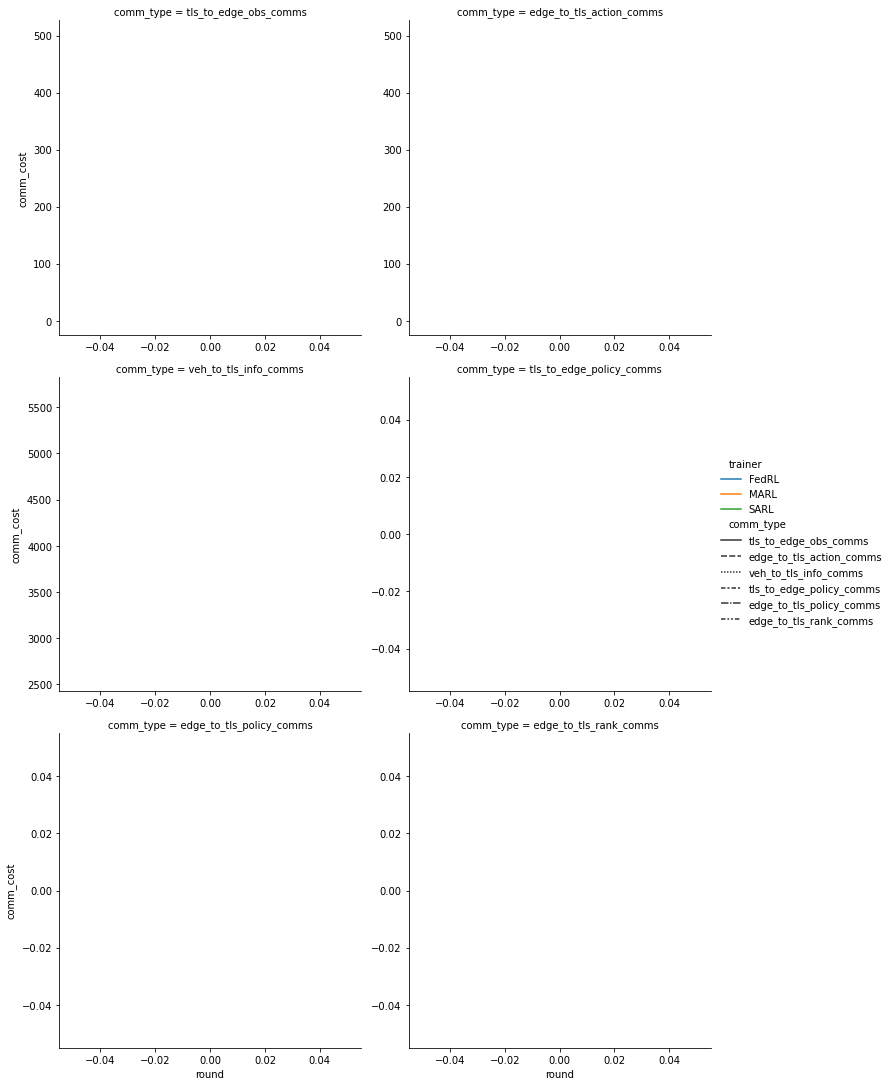

In [10]:
sns.relplot(
    kind="line",
    data=comm_df,
    x="round",
    y="comm_cost",
    hue="trainer",
    style="comm_type",
    col="comm_type",
    col_wrap=2,
    facet_kws={"sharex": False, "sharey": False},
    ci=None
)#.set(yscale="log")
plt.show()